In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm


## Degrees in Telecommunication Engineering, groups 65, 69, 79 and 95
# Modern Theory of Detection and Estimation
### Fall 2020

&nbsp;
&nbsp;
&nbsp;
# Lab 2. Machine Learning for Regression

&nbsp;
&nbsp;
&nbsp;

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;



# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level

The dataset is available in sklearn through [load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes). Take a moment to read the documentation...

Next cell loads the data for you and create the train and test partitions (80-20%, respectively) that we are going to use along this notebook.


In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

data = load_diabetes()
feature_names = data['feature_names'] # list with feature names

X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("{0:d} train observations with {1:d} columns".format(X_train.shape[0], X_train.shape[1]))
print("{0:d} train targets".format(len(X_train)))

print("{0:d} test observations with {1:d} columns".format(X_test.shape[0], X_test.shape[1]))
print("{0:d} test targets".format(len(X_test)))

353 train observations with 10 columns
353 train targets
89 test observations with 10 columns
89 test targets


Once the data set is loaded, analyze the observation matrix X (calculate the mean and standard deviation of your variables) and justify the need or not to normalize the data. If you consider that normalization is necessary, normalize the data in the next cell.

In [ ]:
print("Mean of X_train")
print(np.mean(X_train,0))
print("Standard deviation of X_train")
print(np.std(X_train,0))
print("Mean of X_test")
print(np.mean(X_test,0))
print("Standard deviation of X_test")
print(np.std(X_test,0))

Mean of X_train
[ 0.00144181  0.00018389  0.00173566  0.00117937 -0.00055551 -0.00080601
 -0.000989    0.00037655  0.001216    0.00189101]
Standard deviation of X_train
[0.04626839 0.04757647 0.04720827 0.04840005 0.04771808 0.04756369
 0.04697698 0.04772223 0.0477604  0.04831173]
Mean of X_test
[-0.00571863 -0.00072937 -0.00688413 -0.00467772  0.00220332  0.00319687
  0.00392268 -0.00149352 -0.00482303 -0.00750029]
Standard deviation of X_test
[0.05200108 0.04751323 0.04834517 0.04378653 0.04688892 0.04743625
 0.04963596 0.04690719 0.04647035 0.0436818 ]


# 1. Evaluation of regression methods



The methods you will explore to solve this task are:
- [Regularized linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 
- [Kernel ridge regression with an RBF kernel](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Random Forests for regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [$k$NN for regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
#y=f(x)=w0+w1*K(d1,x)+...+wn*(dn,x)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



### Measure performance: $R^2$ score 

In sklearn regression the *score* by default is the  $R^2$ statistic.
$$
R^2 = 1-\frac{\sum_{i=1}^{N_t}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{N_t}{(y_i-\bar{y})^2}}
$$where $N_t$ is the length of the evaluation set, $\hat{y}_i$, $i=1,\dots,N_t$ are the estimations made by the model, $y_i$ ($i=1,\dots,N_t$)  are the true targets of the evaluation set and $\bar{y}=1/N_t\sum_{i=1}^{N_t}y_i$ is its average.

**$R^2$ interpretation**

$R^2$ takes a maximum value of $1.0$ when the model makes an exact  (0 error) estimation of all the targets. The value of $R^2$ decreases as the estimation errors increase. 

The decrease in $R^2$ value is determined by the comparison between the accuracy of the model in the test set and that of a trivial model that would output as estimation for all the targets their mean value. 

If the model is not perfect ($R^2=0$) but better than the trivial one, then $0 < R^2 < 1$. If $R^2$ falls below 0 and takes negative values, it means that the estimations output by the model are worse than using the mean (trivial estimation). 

 

## 1.1. Selection of hyperparameters for all the regression methods under study

The first task is to obtain a reasonable set of hyperparameters for all the methods. In this assignment the corresponding ranges will be:
- Linear Ridge Regression:
  - `alpha`: 0.0001, 0.001, 0.01, 0.1, 1
- Kernel Ridge Regression:
  - `alpha`: 0.0001, 0.001, 0.01, 0.1, 1
  - `gamma` for the RBF kernel: 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1
- Random Forests:
  - number of estimators: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per tree: 5, 10, 20, 50
- $k$NN:
  - $k$: 1,2,3,5,7,10,15,20,40, 80
  - weight: uniform and distance


*Note*: In class the ridge regressor model had a regularization parameter called $\lambda$. As $\lambda$ is a reserved word in Python, sklearn has called this parameter as `alpha`.


### 1.1.1 Program the grid exploration
The next cell contains the skeleton of the code to construct a GridSearch and performs its exploration with a 10 fold cross validation.

Complete the missing lines.

In [ ]:
def my_grid(model, parameters, X_train, Y_train, X_test, Y_test):
  # model is an estimator
  # parameters is a dictionary with parameters in the GridSearchCV way
  # construct a grid, train it and return the R2 over the test data 
  grid=GridSearchCV(model,parameters,cv=10)
  grid.fit(X_train,Y_train)
  r2_value=grid.score(X_test,Y_test)
  return grid, r2_value


### 1.1.2 Crossvalidate the model parameters 

Now use the function above to find hyperparameters for Random Forest, kNN, ridge regression and kernel ridge regression. Return the values od the selected parameters for each model.

Hint: remember the grid can store a best estimator


### K-NN

In [ ]:
v_nn = [1, 3, 5, 7, 10, 15, 20, 40, 80]
v_w = ['uniform','distance']
parametersknn={'n_neighbors':v_nn,'weights':v_w}
print(parametersknn)
knn=KNeighborsRegressor()
gridknn,r2valueknn=my_grid(knn,parametersknn,X_train,Y_train,X_test,Y_test)
print(r2valueknn)
print(gridknn.best_params_)

{'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 40, 80], 'weights': ['uniform', 'distance']}
0.43452846638964693
{'n_neighbors': 20, 'weights': 'distance'}


### Random Forest

In [ ]:
v_ntrees = [10, 20, 50, 100, 200, 500, 1000]
v_leaves = [5, 10, 20, 50] 
parametersRF={'n_estimators':v_ntrees,'max_leaf_nodes':v_leaves}
print(parametersRF)
RF=RandomForestRegressor()
gridRF,r2valueRF=my_grid(RF,parametersRF,X_train,Y_train,X_test,Y_test)
print(r2valueRF)
print(gridRF.best_params_)

{'n_estimators': [10, 20, 50, 100, 200, 500, 1000], 'max_leaf_nodes': [5, 10, 20, 50]}
0.44635164946964345
{'max_leaf_nodes': 20, 'n_estimators': 50}


### Ridge Regression

In [ ]:
v_alpha = [0.0001, 0.001, 0.01, 0.1, 1]

parametersR={'alpha':v_alpha}
print(parametersR)
RidgeR=Ridge()
gridR,r2valueR=my_grid(RidgeR,parametersR,X_train,Y_train,X_test,Y_test)
print(r2valueR)
print(gridR.best_params_)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
0.4608531678297328
{'alpha': 0.1}


### Kernel Ridge Regression

In [ ]:
v_alpha = [0.0001, 0.001, 0.01, 0.1, 1]
v_gamma = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

parametersKR={'alpha':v_alpha,'gamma':v_gamma}
print(parametersKR)
KernelR=KernelRidge(kernel='rbf')
gridKR,r2valueKR=my_grid(KernelR,parametersKR,X_train,Y_train,X_test,Y_test)
print(r2valueKR)
print(gridKR.best_params_)


{'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'gamma': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]}
0.4613522704926605
{'alpha': 0.01, 'gamma': 0.05}


### 1.1.3 Discussion

Analyze which method is better than the others in terms of $R^2$ score.

$ANSWER:$ The best method in terms of $R^2$ is the random forest.

## 1.2. Measures of training and evaluation time





### 1.2.1. Compute time and test times

Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to obtain estimations of the **time needed to train each method** and the **time needed to evaluate a test set**. Select 10 folds to express the measures with mean and standard deviations.  **Use the best set of hyperparameters in terms of $R^2$ found in the previous cell**. 

In [ ]:
from sklearn.model_selection import  cross_validate
#<SOL>
knn=KNeighborsRegressor(n_neighbors=20, weights='distance')
RF=RandomForestRegressor(max_leaf_nodes=20,n_estimators=200)
RidgeR=Ridge(alpha=0.1)
KernelR=KernelRidge(alpha=0.01,gamma=0.05, kernel='rbf')
scoresknn1=cross_validate(knn,X_train,Y_train,cv=10)
scoresknn2=cross_validate(knn,X_test,Y_test,cv=10)
scoresRF1=cross_validate(RF,X_train,Y_train,cv=10)
scoresRF2=cross_validate(RF,X_test,Y_test,cv=10)
scoresR1=cross_validate(RidgeR,X_train,Y_train,cv=10)
scoresR2=cross_validate(RidgeR,X_test,Y_test,cv=10)
scoresKR1=cross_validate(KernelR,X_train,Y_train,cv=10)
scoresKR2=cross_validate(KernelR,X_test,Y_test,cv=10)

knn_train_time=scoresknn1['fit_time']
knn_evaluation_time=scoresknn2['score_time']
RF_train_time=scoresRF1['fit_time']
RF_evaluation_time=scoresRF2['score_time']
RidgeR_train_time=scoresR1['fit_time']
RidgeR_evaluation_time=scoresR2['score_time']
KernelR_train_time=scoresKR1['fit_time']
KernelR_evaluation_time=scoresKR2['score_time']

print("Knn training time: ",np.mean(knn_train_time)*10)
print("Knn evaluation time: ", np.mean(knn_evaluation_time))
print("Random forest training time: ",np.mean(RF_train_time)*10)
print("Random forest evaluation time: ", np.mean(RF_evaluation_time))
print("Ridge training time: ",np.mean(RidgeR_train_time)*10)
print("Ridge evaluation time: ", np.mean(RidgeR_evaluation_time))
print("Kernel ridge training time: ",np.mean(KernelR_train_time)*10)
print("Kernel ridge evaluation time: ", np.mean(KernelR_evaluation_time))
#</SOL>

Knn training time:  0.006926774978637695
Knn evaluation time:  0.0012816429138183595
Random forest training time:  3.687688112258911
Random forest evaluation time:  0.010949110984802246
Ridge training time:  0.005003929138183594
Ridge evaluation time:  0.000464940071105957
Kernel ridge training time:  0.07672953605651855
Kernel ridge evaluation time:  0.001094985008239746


### 1.2.2. Visual representation
Produce a (1,2) subplot with the following information:
- left panel: scatter plot of the performance of the 5 methods. The x axis is the **time to fit** and the y axis is the $R^2$. Each method should have a single marker with a different color. Use the legend to identify methods

- right panel: The x axis is the **time to score** and the y axis is the $R^2$. Each method should have a single marker with a different color. Use the legend to identify methods

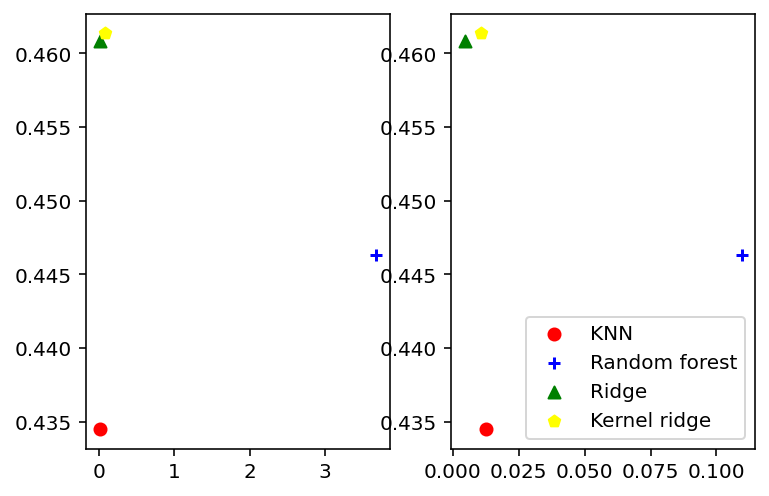

In [ ]:
#<SOL>
import matplotlib.pyplot as plt
R2values=[r2valueknn,r2valueRF,r2valueR,r2valueKR]
Fitting_times=[np.mean(knn_train_time),np.mean(RF_train_time),np.mean(RidgeR_train_time),np.mean(KernelR_train_time)]
Scoring_times=[np.mean(knn_evaluation_time),np.mean(RF_evaluation_time),np.mean(RidgeR_evaluation_time),np.mean(KernelR_evaluation_time)]

plt.subplot(121)
plt.scatter(np.mean(knn_train_time)*10,r2valueknn,c="red",marker='o',label="KNN")
plt.scatter(np.mean(RF_train_time)*10,r2valueRF,c="blue",marker='+',label="Random forest")
plt.scatter(np.mean(RidgeR_train_time)*10,r2valueR,c="green",marker='^',label="Ridge")
plt.scatter(np.mean(KernelR_train_time)*10,r2valueKR,c="yellow",marker=(5,0),label="Kernel ridge")
#plt.scatter(Fitting_times,R2values,c=(255,100,200,50),marker='o')
plt.subplot(122)
plt.scatter(np.mean(knn_evaluation_time)*10,r2valueknn,c="red",marker='o',label="KNN")
plt.scatter(np.mean(RF_evaluation_time)*10,r2valueRF,c="blue",marker='+',label="Random forest")
plt.scatter(np.mean(RidgeR_evaluation_time)*10,r2valueR,c="green",marker='^',label="Ridge")
plt.scatter(np.mean(KernelR_evaluation_time)*10,r2valueKR,c="yellow",marker=(5,0),label="Kernel ridge")
#plt.scatter(Scoring_times,R2values,c=(255,100,200,50),marker='^')

plt.legend(loc=4)
plt.show()
#</SOL>

### 1.2.3. Discussion

Use the plots to describe the advantages and disadvantages of each method

$ANSWER:$ The Random Forest is the best in terms of accuracy, but it's also the one that takes the most time to train and evaluate.

The KNN is the one that has the lowest accuracy, but it´s much quicker than random forest, even thought it's not the quickest.

Both, ridge and kernel ridge regressors, are the best if we take both accuracy and time into account, being the kernel ridge slightly more accurate than the ridge, but a bit slower too.

# 2. Feature selection

The goal in this assignment is to learn how to use machine learning for improving our domain learning about a problem. In this case the problem is to study the dependence of the progress of diabetes with the variables that characterize each patient. You want to learn:
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure)
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

Next sections propose you several approaches to carry out this feature selection.


## 2.1. Univariate Feature Selection


### 2.1.1. Univariate Feature Selection with linear regression

As there are 10 input variables, one can solve 10 1D problems and see what is the best variable if we had to stick to a model with a single variable. 

- Construct the 10 linear models (using a linear ridge regressor)
- Crossvalidate, with a 10 fold CV, their `alpha` parameters in the range `alpha`: 0.001, 0.01, 0.1, 1
- Plot $5\times 2$ the model with scatters, print in the title the $R^2$

Which variable is more critical to predict the disease progression?

$ANSWER:$ We can see that the column with the highest mean squared error is the third, i.e., the most critical variable is the bmi. 

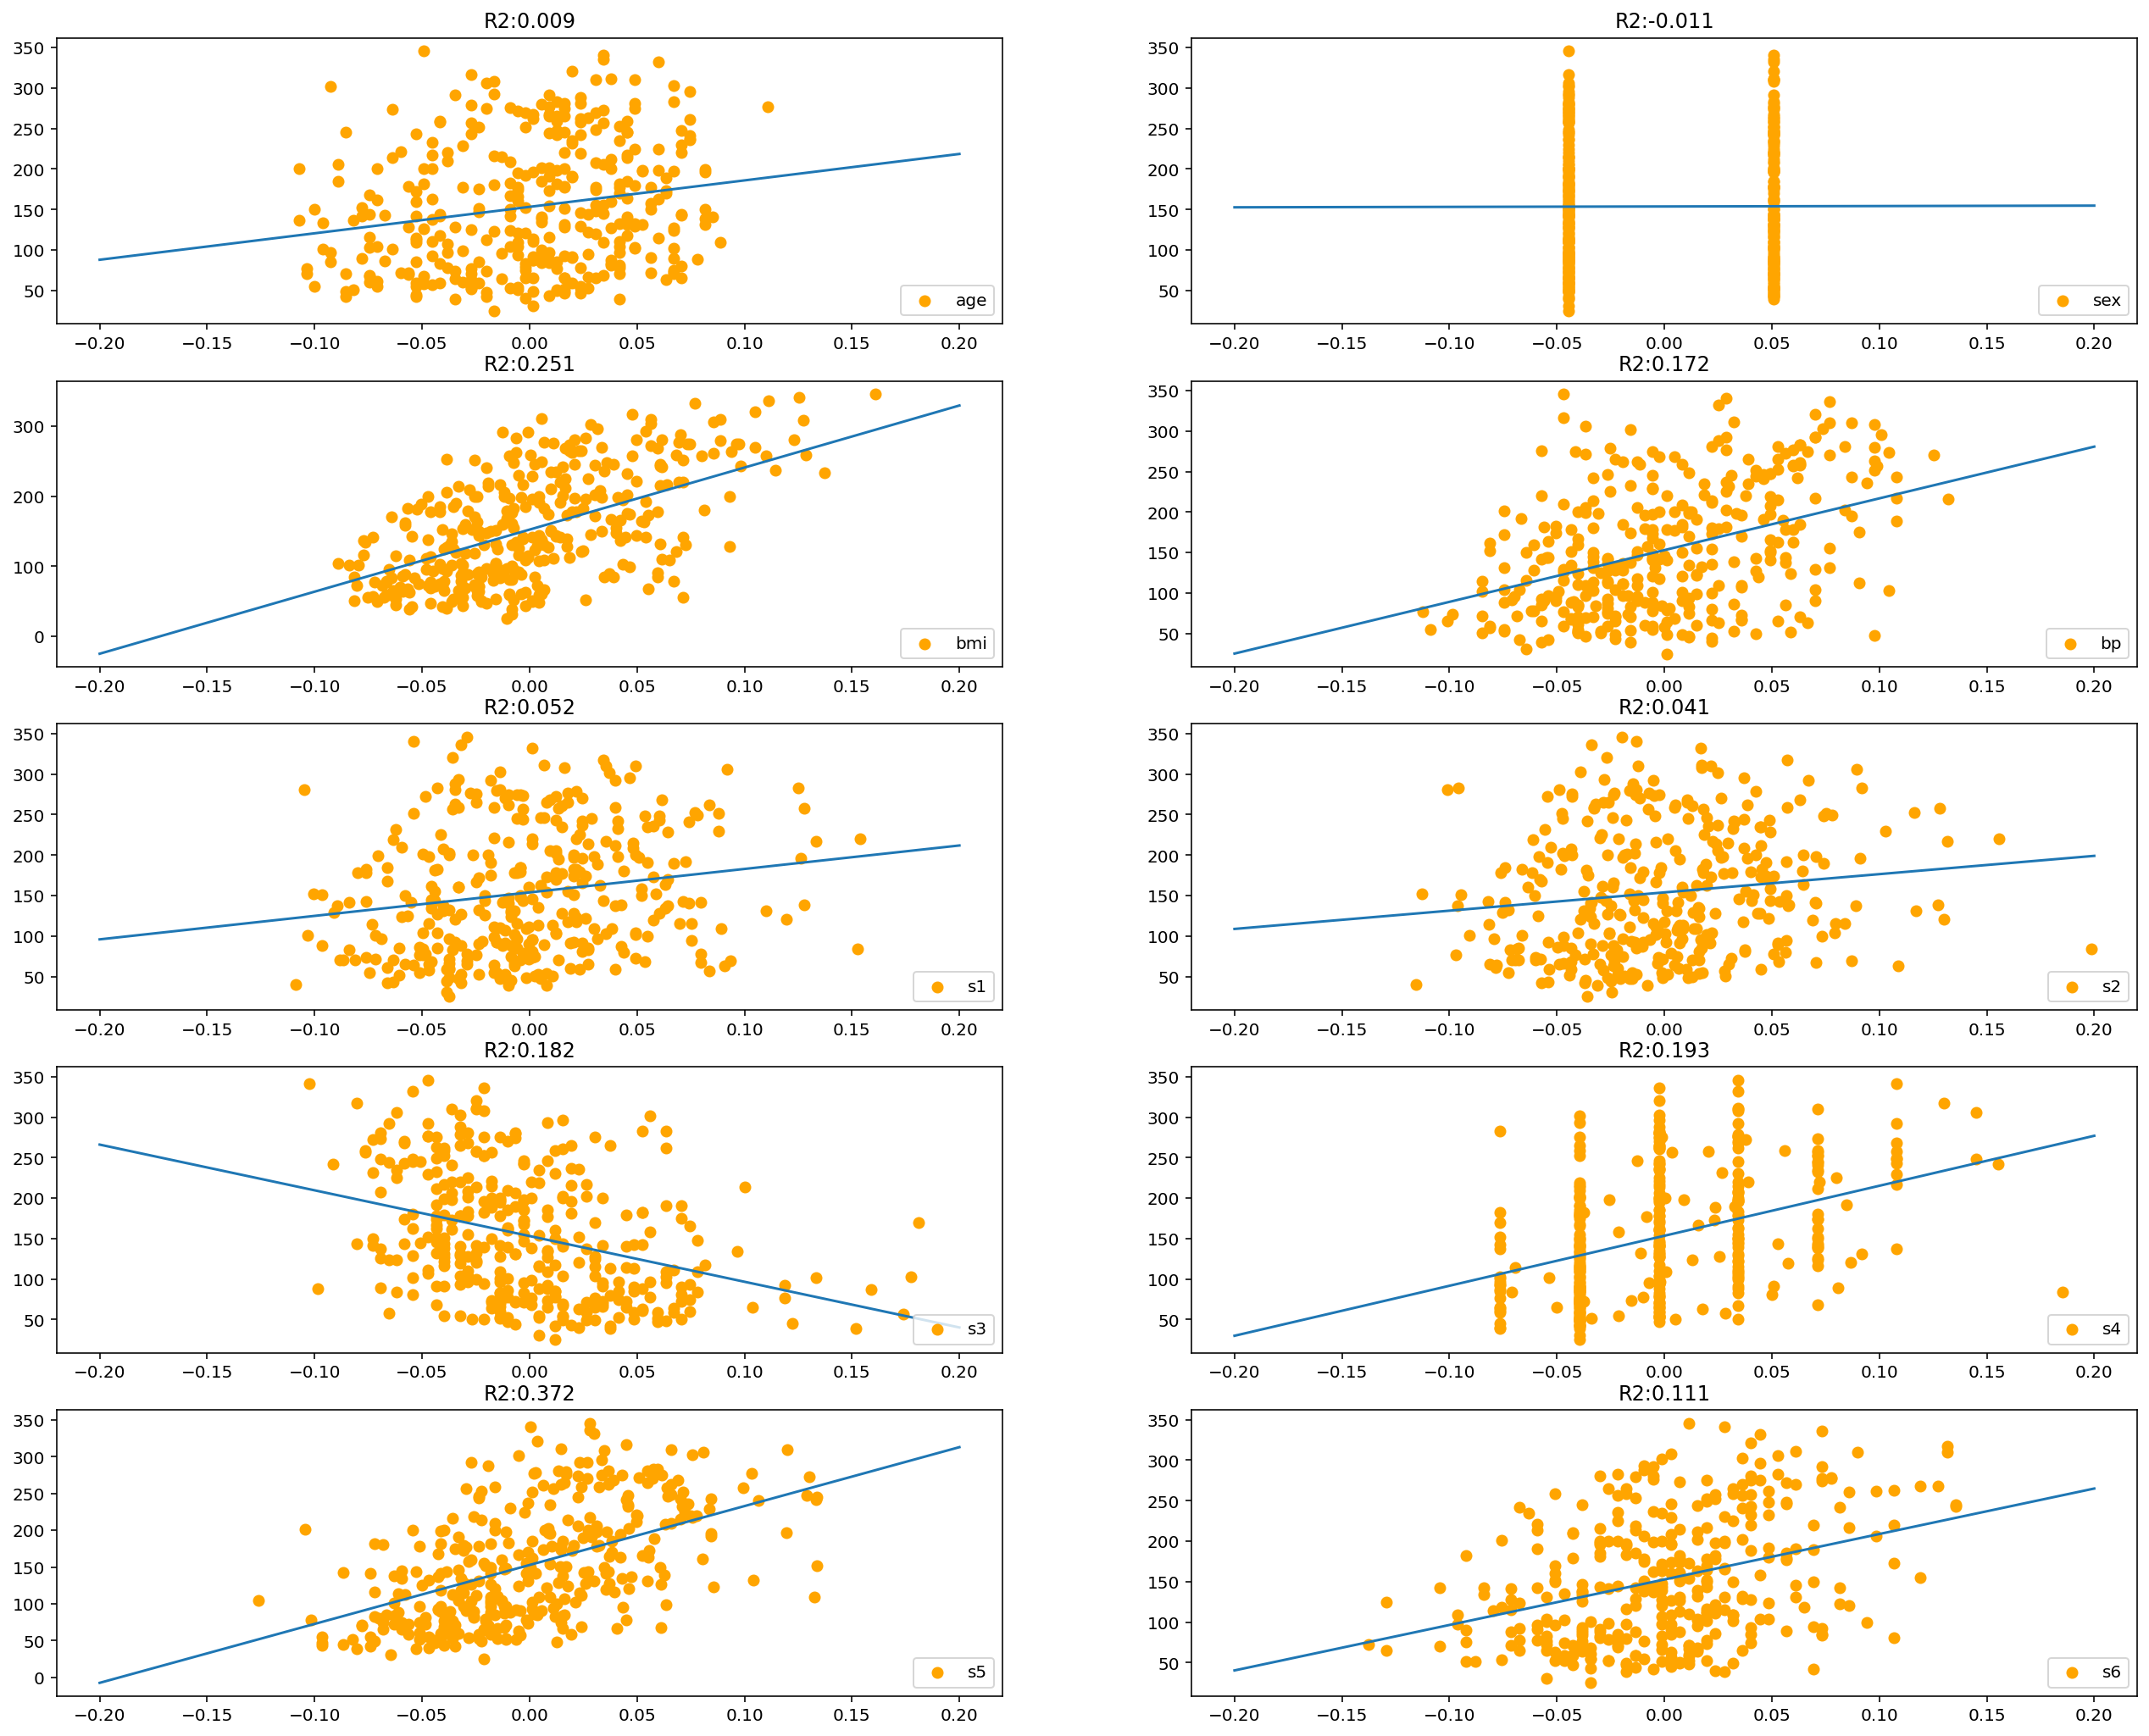

In [ ]:
from sklearn.model_selection import GridSearchCV
#<SOL>

x=np.linspace(start=-0.2,stop=0.2,num=100)
x=x[:,np.newaxis]
fig,ax=plt.subplots(ncols=2,nrows=5,figsize=(22,18))
for i in range(10):
  xx=int(i/2)
  yy=i%2
  X_train_tmp=X_train[:,i:i+1]
  X_test_tmp=X_test[:,i:i+1]
  RidgeR=Ridge()
  alpha=[0.001,0.01,0.1,1]
  parameters={'alpha':alpha}
  grid,r2_value=my_grid(RidgeR,parameters,X_train_tmp,Y_train,X_test_tmp,Y_test)
  y=grid.predict(x)
 
  ax[xx,yy].scatter(X_train_tmp,Y_train,marker='o',color="orange",label=feature_names[i])
  ax[xx,yy].plot(x,y)
  ax[xx,yy].set_title('R2:%1.3f' %r2_value)
  ax[xx,yy].legend(loc=4)
#</SOL>

### 2.1.2. Univariate Feature Selection with no linear regression 

Repeat the 1D analysis with Kernel ridge using a RBF kernel. Now, besides `alpha`, cross validate `gamma` using these ranges:
  - `alpha`: 0.001, 0.01, 0.1, 1
  - `gamma` for the RBF kernel: 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1


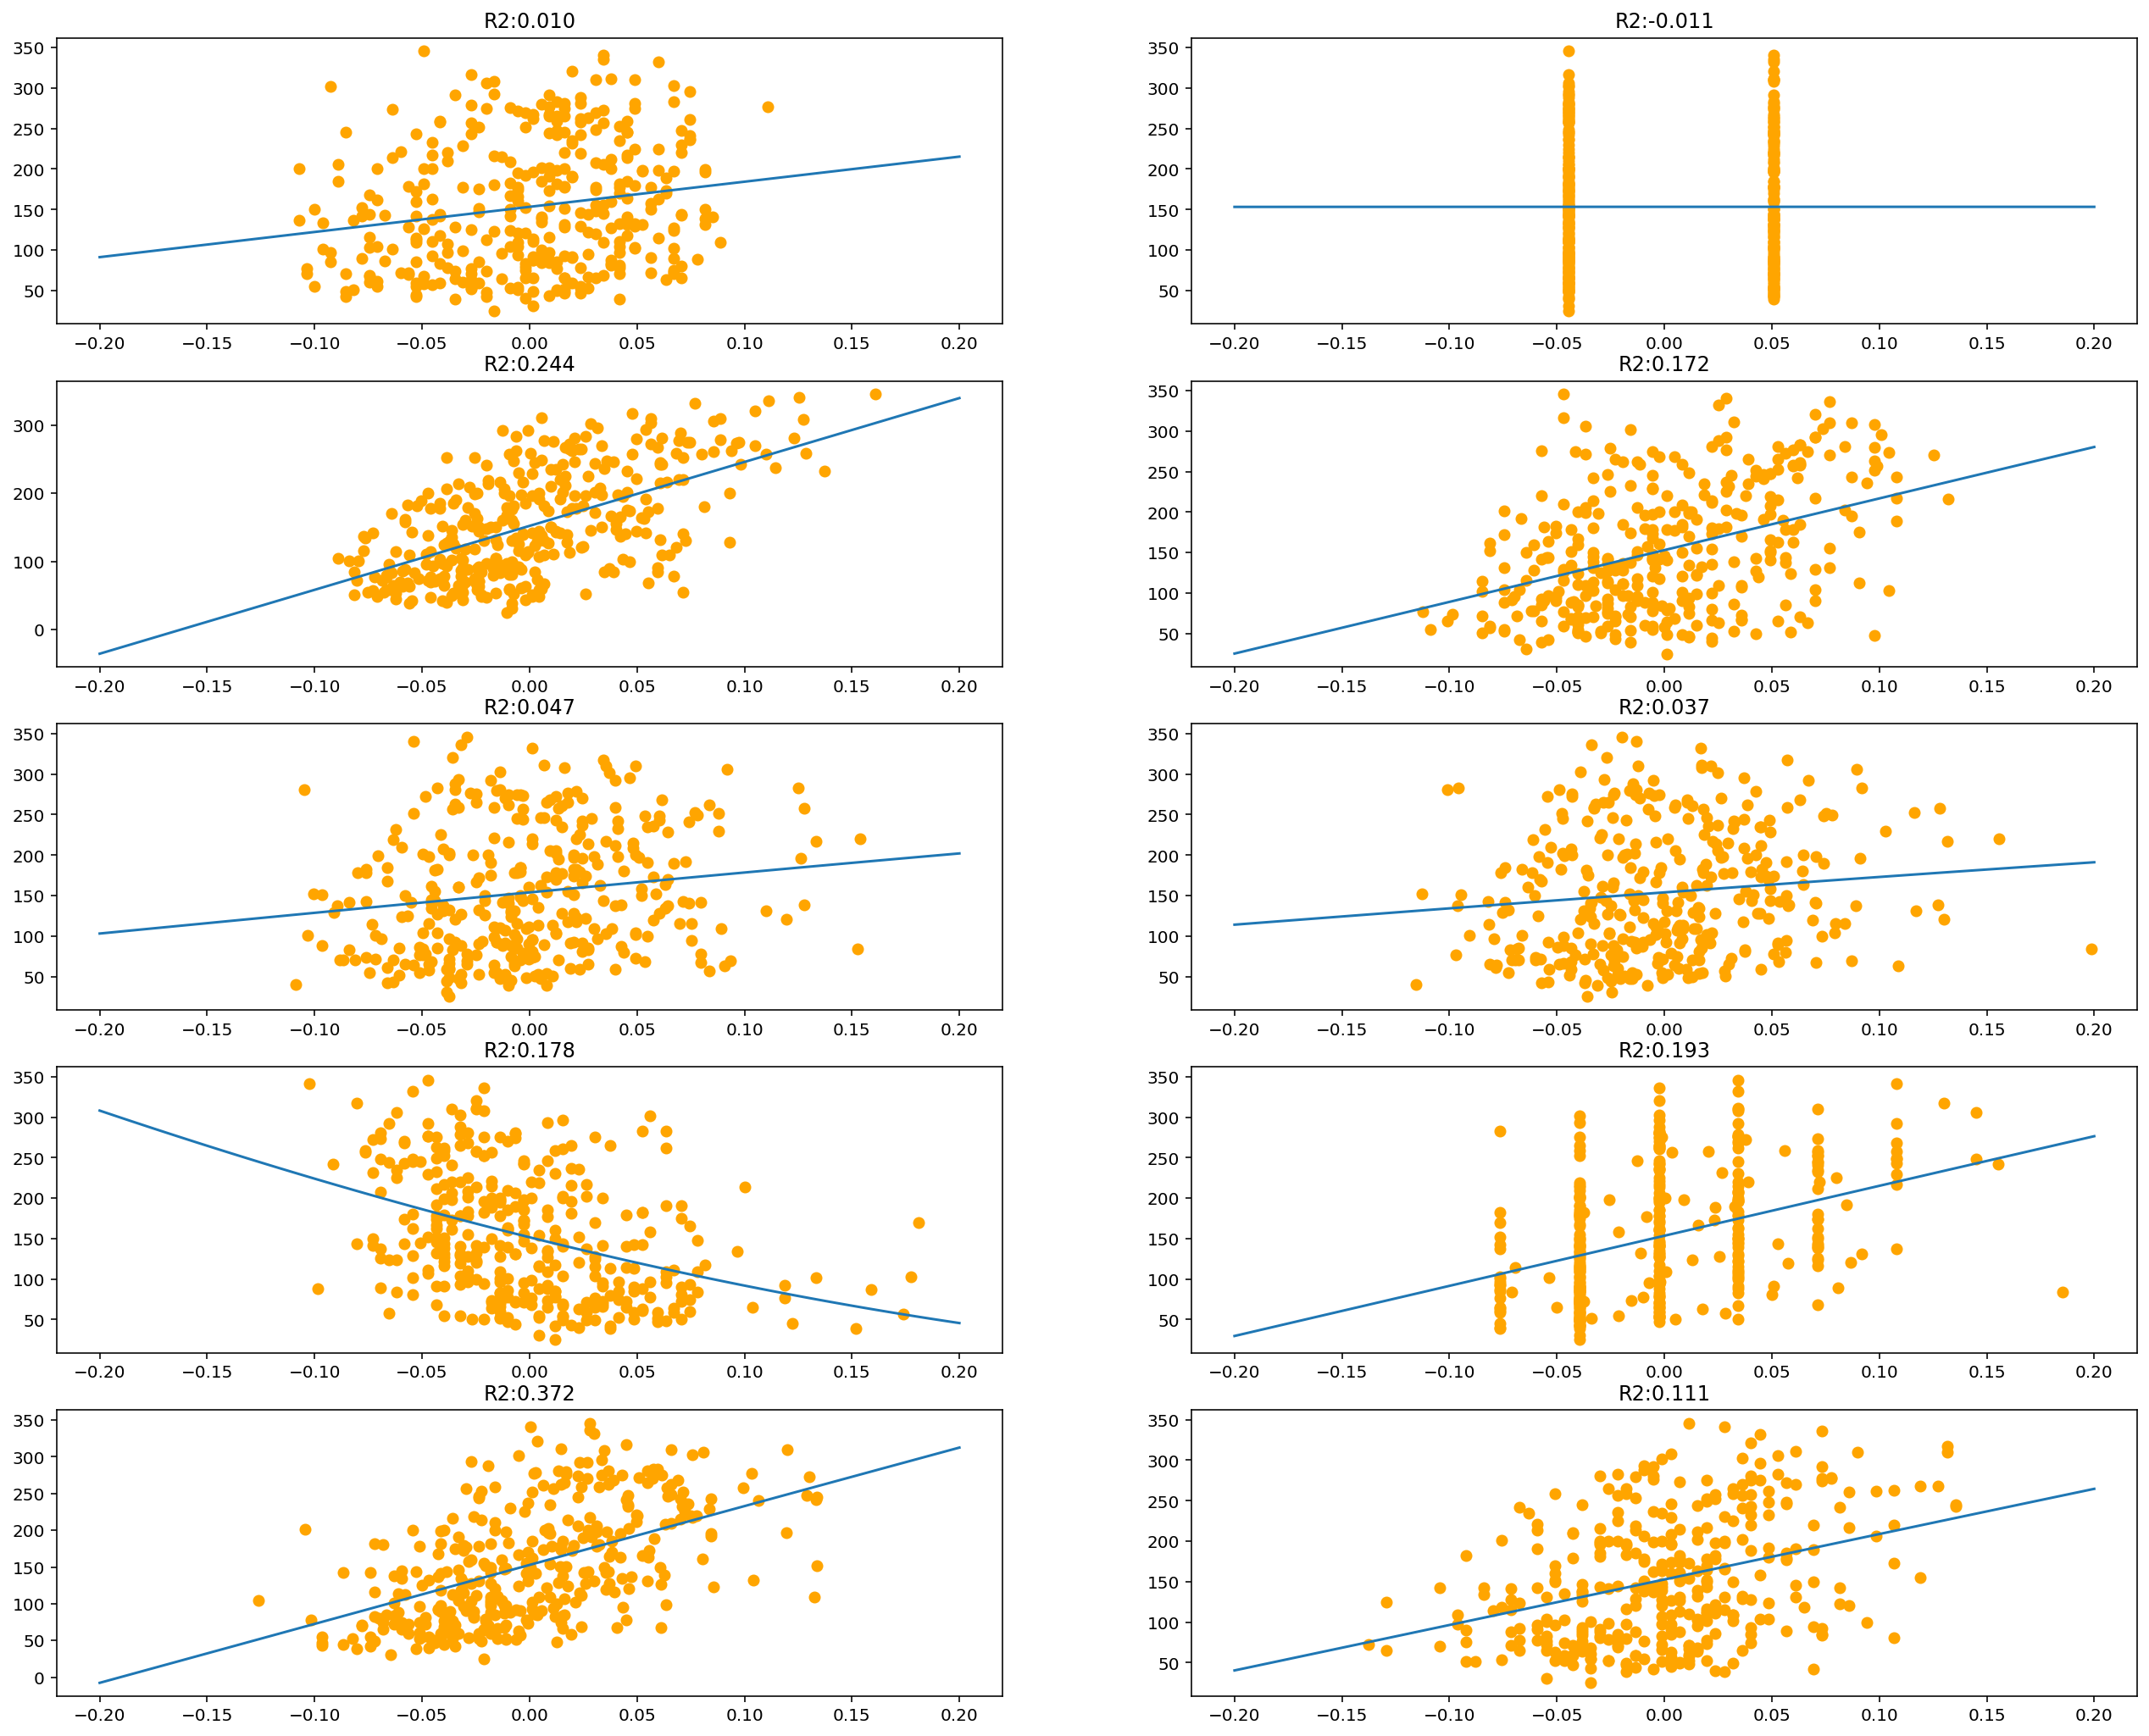

In [ ]:
#<SOL>
from sklearn.model_selection import GridSearchCV
#<SOL>
x=np.linspace(start=-0.2,stop=0.2,num=100)
x=x[:,np.newaxis]
fig,ax=plt.subplots(ncols=2,nrows=5,figsize=(22,18))
for i in range(10):
  xx=int(i/2)
  yy=i%2
  X_train_tmp=X_train[:,i:i+1]
  X_test_tmp=X_test[:,i:i+1]
  KernelR=KernelRidge(kernel='rbf')
  alpha=[0.001,0.01,0.1,1]
  gamma=[0.01,0.01,0.05,0.1,0.2]
  parameters={'alpha':alpha, 'gamma':gamma}
  grid=GridSearchCV(KernelR, parameters,cv=10)
  grid.fit(X_train_tmp,Y_train)
  r2_value=grid.score(X_test_tmp,Y_test)
  y=grid.predict(x) 
  ax[xx,yy].scatter(X_train_tmp,Y_train,marker='o',color="orange",)
  ax[xx,yy].plot(x,y)
  ax[xx,yy].set_title('R2:%1.3f' %r2_value)
#</SOL>


### 2.1.3 Discussion

Was it worth to add the nonlinearity? Is there any variable for which the nonlinear model improves the linear one?

$ANSWER:$ Even though the score for is improved by 0.01 in the age, it´s not worth it to add nonlinearity, as in the remaining variables the score is equal or worse.

## 2.2. Multivariate Feature Selection: Recursive Feature Selection

After selecting reasonable values for the hyperparameters, you are going to focus on the main goal of this study: Learn which are the most relevant variables to predict the targets.

[Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is a commonly used framework for this purpose. It basically consists in starting with an estimator fitted with all the variables and recursively withdraw from the training set that variable that achieves a smallest relevance score. In linear regression this score is the absolute value of the weight of that variable in the regressor.

However, a major limitation of the RFE implementation of sklearn is that it only works with those estimators that implement a method to assess the relevance of the variables. 

In this section you are going to code up a version of RFE that uses the crossvalidation error to decide which variable will be removed at each iteration.

The skeleton of the code of the function is the following:

1. Loop that runs $d-1$ times, where $d$ is the number of variables (notice if at each iteration one variable is removed after $d-1$ iterations you only have one surviving variable)

    1.1. Within the $i$-th iteration of the main loop (it means you have removed $i$ variables, therefore there remain $d-i$ variables to explore). Create a `r2_score` empty array with `d-i` positions. Then run another loop for $j=1,\dots, d-i$ iterations:

      1.1.1 Make a copy of your training data and remove one of the remaining $d-i$ features. Name `Z` the $N\times (d-i-1)$ resulting data matrix. If this is the $j$-th iteration of this inner loop, let's consider `Z` results from removing column $j$ of the data matrix (that now has only $d-i$ columns). Assume the $j$ column corresponds to the original variable $v_j$ ($v_j$ is the actual position of column $j$ in the original data matrix $X$ with 10 columns).

      1.1.2. Run a crossvalidation with `Z` and `Y`. Annotate the mean score of the crossvalidation in the $j$-th position of `r2_score`. This is your estimation of the performance when you drop variable $v_j$ (after having droppped the $i$ columns you have already dropped in the previous iterations)

  1.2 Use `r2_score` to decide which is the variable you are dropping in the $i$-th iteration of the main loop. Will it be the position of the maximum or of the minimum in `r2_score`?

  1.3 Drop the corresponding column of the data matrix, now your data matrix has $d-i-1$ columns.


### 2.2.1 Program the grid exploration

Before programming the RFE alogrithm, let us redesign the code of the Section 1.1.1. Now, this function has to cross validate the model parameters, obtain its $R^2$ score over the test data but, additionaly, it has to obtain the average  cross-validated  $R^2$ score of the model for the selected parameters. Check the content of the atributte `best_score_` after fitting the GridSearch object.


In [ ]:
def mi_grid(model, parameters, X_train, Y_train, X_test, Y_test):
  # model is an estimator
  # parameters is a dictionary with parameters in the GridSearchCV way
  # construct a grid, train it and return the R2 over the test data and 
  # the averaged cross-validated score of the best model
  grid=GridSearchCV(model,parameters,cv=10)
  grid.fit(X_train,Y_train)
  r2_value_test=grid.score(X_test,Y_test)
  r2_value_CV = grid.best_score_ 
  return grid, r2_value_CV, r2_value_test


### 2.2.1 Program the RFE algorithm

In [ ]:
def mi_RFE(model, parameters, X_train, Y_train, X_test, Y_test):
  # Some initializations
  N_tr, num_variables = X_train.shape
  N_test, num_variables = X_test.shape
  remaining_variables = [cc for cc in range(num_variables)]
  removed_variables = []
  score_after_remotion_test = []
  
  """
  YOUR CODE

  1.loop for num_variables -1 iterations
     1.1 create r2_scores_CV and r2_scores_test, empty arrays with length equal to the number of remaining variables
     1.2 loop for, j runs for the number of remaining variables:
         1.2.1 Create Z_train and Z_test, a copy of the columns of X_train and X_test in list remaining_variables dropping j
         1.2.2 Crossvalidate estimator wsing the my_grid with Z_train, Y_train, Z_test, Y_test
         1.2.3 Store in r2_scores_CV and r2_scores_test the returned variables r2_value_CV and r2_value_test
     1.3 decide which variable is going to be dropped in this iteration
     1.4 update remaining_variables
     1.5 update removed_variables
     1.6 update score_after_remotion_test
  2. update removed_variables with the survivor after removing num_variables-1 variables
  3. return removed_variables, score_after_remotion

  """
  #<SOL>
  for i in range(9):
    r2_value_aux=0
    index=0
    r2_scores_CV=np.zeros(len(remaining_variables))
    r2_scores_test =np.zeros(len(remaining_variables))
    for j in range(len(remaining_variables)):
      X_train_aux=np.empty((N_tr,len(remaining_variables)))
      X_test_aux=np.empty((N_test,len(remaining_variables)))
      for k in range(len(remaining_variables)):
        X_train_aux[:,k]=X_train[:,remaining_variables[k]]
        X_test_aux[:,k]=X_test[:,remaining_variables[k]]
      Z_train=np.delete(X_train_aux,j,1)
      Z_test=np.delete(X_test_aux,j,1)
      grid,r2_value_CV,r2_value_test=mi_grid(model,parameters,Z_train,Y_train,Z_test,Y_test)
      if r2_value_test>=r2_value_aux:
        r2_value_aux=r2_value_test
        index=j
        removed=remaining_variables[j]
    remaining_variables=np.delete(remaining_variables,index)
    removed_variables=np.append(removed_variables,removed)
    score_after_remotion_test=np.append(score_after_remotion_test,r2_value_aux)
  return removed_variables,score_after_remotion_test    
  #</SOL>

Use the function above to obtain the ranking in which the variables would be removed by the following methods:
- k-NN
- Random Forest
- Ridge Regression
- Kernel Ridge Regression

using the same parameter ranges of Section 1. For the Random Forest algorithm (to speed up the CV process) you can fix the number of trees (`n_estimators`) to 100 and only cross validate `max_leaf_nodes`. Be patient running this code...

In [ ]:
#<SOL>
#RIGDE REGRESSOR
print("RIGDE REGRESSOR\n")
RidgeR=Ridge()
alpha=[0.001,0.01,0.1,1]
parameters={'alpha':alpha}
removed_variables,score_after_remotion_test=mi_RFE(RidgeR,parameters,X_train,Y_train,X_test,Y_test)
for i in range(len(removed_variables)):
  removed_variable=feature_names[int(removed_variables[i])]
  print("Score after removing ",removed_variable," for ridge regressor: %1.3f"%score_after_remotion_test[i])

#KNeighbors
print("KNeighbors\n")
v_nn = [1, 3, 5, 7, 10, 15, 20, 40, 80]
v_w = ['uniform','distance']
parametersknn={'n_neighbors':v_nn,'weights':v_w}
knn=KNeighborsRegressor()
removed_variables,score_after_remotion_test=mi_RFE(knn,parametersknn,X_train,Y_train,X_test,Y_test)
for i in range(len(removed_variables)):
  removed_variable=feature_names[int(removed_variables[i])]
  print("Score after removing ",removed_variable," for KNeighbors: %1.3f"%score_after_remotion_test[i])

#RANDOM FOREST
print("RANDOM FOREST\n")
v_ntrees = [100]
v_leaves = [5, 10, 20, 50] 
parametersRF={'n_estimators':v_ntrees,'max_leaf_nodes':v_leaves}
RF=RandomForestRegressor()
removed_variables,score_after_remotion_test=mi_RFE(RF,parametersRF,X_train,Y_train,X_test,Y_test)
for i in range(len(removed_variables)):
  removed_variable=feature_names[int(removed_variables[i])]
  print("Score after removing ",removed_variable," for random forest: %1.3f"%score_after_remotion_test[i])

#KERNEL RIDGE
print("KERNEL RIDGE\n")
v_alpha = [0.0001, 0.001, 0.01, 0.1, 1]
v_gamma = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
parametersKR={'alpha':v_alpha,'gamma':v_gamma}
KernelR=KernelRidge(kernel='rbf')
removed_variables,score_after_remotion_test=mi_RFE(KernelR,parametersKR,X_train,Y_train,X_test,Y_test)
for i in range(len(removed_variables)):
  removed_variable=feature_names[int(removed_variables[i])]
  print("Score after removing ",removed_variable," for Kernel ridge: %1.3f"%score_after_remotion_test[i])

#</SOL>

RIGDE REGRESSOR

Score after removing  age  for ridge regressor: 0.467
Score after removing  s4  for ridge regressor: 0.471
Score after removing  s1  for ridge regressor: 0.473
Score after removing  s2  for ridge regressor: 0.475
Score after removing  bp  for ridge regressor: 0.474
Score after removing  s6  for ridge regressor: 0.469
Score after removing  sex  for ridge regressor: 0.460
Score after removing  s3  for ridge regressor: 0.455
Score after removing  bmi  for ridge regressor: 0.372
KNeighbors

Score after removing  s2  for KNeighbors: 0.480
Score after removing  s1  for KNeighbors: 0.495
Score after removing  s6  for KNeighbors: 0.478
Score after removing  s3  for KNeighbors: 0.486
Score after removing  s4  for KNeighbors: 0.497
Score after removing  age  for KNeighbors: 0.487
Score after removing  bp  for KNeighbors: 0.490
Score after removing  sex  for KNeighbors: 0.465
Score after removing  bmi  for KNeighbors: 0.396
RANDOM FOREST

Score after removing  age  for random for

**Compare the 4 rankings**

Looking at the rankings of the removed variables and the validation scores that the different methods achieve once these variables have been removed, categorize the 10 variables in these three groups:

- **Essential variables**: When one of these variables is removed the performance starts to worsen significantly.
- **Noisy variables**: Removing these variables makes the performance better
- **Redundant variables**: These variables can be removed without affecting the performance, as with high probability the information that they carry is also present in other variables.

**Justify your answer**

$ANSWER:$ 

- **Noisy variables**: age.
- **Redundant variables**:s4.
- **Essential variables**:bmi, s5,bp.

# 3. Role of each variable in the model

Besides the importance of each variable in the prediction of the targets evaluated in Section 2, some of the models enable to analize the role of each variable within the predictive function $f(\mathbf x)$.



## 3.1. Linear regression case
In the linear regression case
$$
f(\mathbf x) = \mathbf w^\top \mathbf x + w_0 = w_0 + \sum_{k=1}^d w_kx_k
$$each variable $x_k$ contribution to the predictive function is its value multiplied by the weight $w_k$.

**Relate the value of $w_k$ with the relevance of $x_k$**.

Retrieve the weights of the `best_estimator_` for the ridge regressor in Section 1.1 and compare this relevance of the variables based on these weights with the ranking of variables found in Section 2.2 (for the Ridge ression model).

Hint: Think about the sign and the absolute value of $w_k$.

In [ ]:
#<SOL>
RidgeR=Ridge()
alpha=[0.001,0.01,0.1,1]
parameters={'alpha':alpha}
grid=GridSearchCV(RidgeR,parameters,cv=10)
grid.fit(X_train,Y_train)
coeffs=grid.best_estimator_.coef_
ordered_coeffs=[]
variables=[]
coeffs_aux=coeffs
for i in range(len(coeffs)):
  coeff=0
  for j in range(len(coeffs_aux)):
    if abs(coeffs_aux[j])>coeff:
      coeff=abs(coeffs_aux[j])
      index=j
  for j in range(len(coeffs)):
    if coeff==abs(coeffs[j]):
      variable=feature_names[j]
  coeffs_aux=np.delete(coeffs_aux,index)
  ordered_coeffs=np.append(ordered_coeffs,coeff)
  variables=np.append(variables,variable)
for i in range(len(ordered_coeffs)):
  print("Weight of ",variables[i], "is: ", ordered_coeffs[i])

#</SOL>

Weight of  bmi is:  505.08633402034786
Weight of  s5 is:  392.287281637796
Weight of  bp is:  317.0987736516991
Weight of  sex is:  205.49571833015813
Weight of  s3 is:  190.36567438363303
Weight of  s4 is:  151.70673169925894
Weight of  s1 is:  108.4982982521636
Weight of  s2 is:  86.23875989698416
Weight of  s6 is:  79.90836219282711
Weight of  age is:  42.853744706941185


**Include your discussion here!**

$ANSWER:$ we can see that the order of the weights keeps some similarity to the order in which the variables were removed.

## 3.2 Decision Tree

Plot a decision tree with the code of the lecture notebook and interpret the relevance of the variables. 

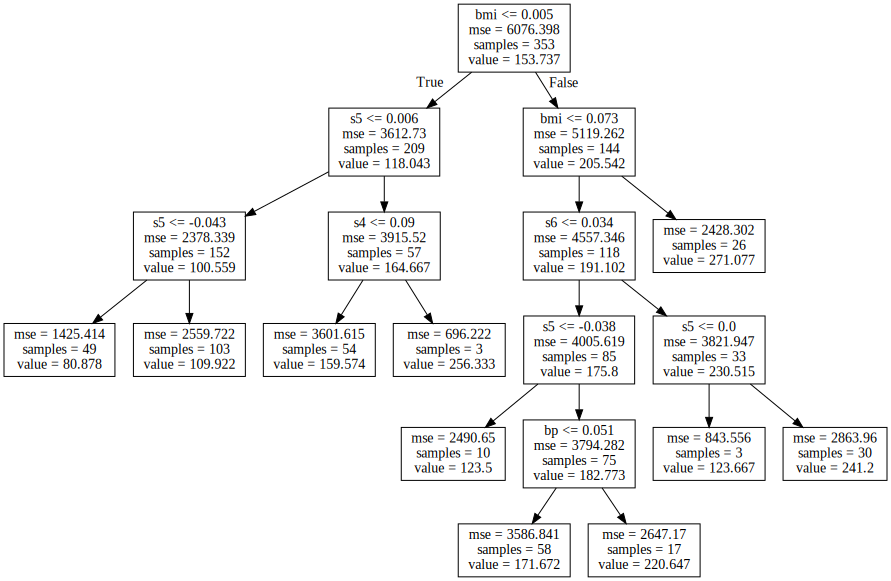

In [ ]:
#<SOL>
from sklearn import tree
import graphviz

DT=DecisionTreeRegressor(max_leaf_nodes=10)
DT.fit(X_train,Y_train)
my_tree=tree.export_graphviz(DT,feature_names=feature_names)

graph = graphviz.Source(my_tree)
graph
#</SOL>

**Include your discussion here!**

$ANSWER$: we can see that the first nodes were divided depending on the variables with a biiger weight, and that as we go down the tree, the variables taken into account to divide the nodes are less important in terms of weight.

## 3.3. Random Forest

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these tests, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.

**Retrieve the weights of the `best_estimator_` for the random forest in Section 1.1 and compare this relevance score  with the ranking of variables found in Section 2.2.**

In [ ]:
#<SOL>
v_ntrees = [100]
v_leaves = [5, 10, 20, 50] 
parametersRF={'n_estimators':v_ntrees,'max_leaf_nodes':v_leaves}
RF=RandomForestRegressor()
grid=GridSearchCV(RF,parametersRF,cv=10)
grid.fit(X_train,Y_train)
coeffs=grid.best_estimator_.feature_importances_
ordered_coeffs=[]
variables=[]
coeffs_aux=coeffs
for i in range(len(coeffs)):
  coeff=0
  for j in range(len(coeffs_aux)):
    if abs(coeffs_aux[j])>coeff:
      coeff=abs(coeffs_aux[j])
      index=j
  for j in range(len(coeffs)):
    if coeff==abs(coeffs[j]):
      variable=feature_names[j]
  coeffs_aux=np.delete(coeffs_aux,index)
  ordered_coeffs=np.append(ordered_coeffs,coeff)
  variables=np.append(variables,variable)
for i in range(len(ordered_coeffs)):
  print("Weight of ",variables[i], "is: ", ordered_coeffs[i])
#</SOL>

Weight of  bmi is:  0.4538487027970054
Weight of  s5 is:  0.3388241369914198
Weight of  bp is:  0.06545309674819184
Weight of  s6 is:  0.04053196900733375
Weight of  s3 is:  0.024909097896186835
Weight of  s2 is:  0.021909640530010908
Weight of  age is:  0.020556359937145774
Weight of  s4 is:  0.01717603578791502
Weight of  s1 is:  0.01585621881412892
Weight of  sex is:  0.0009347414906616265


**Include your discussion here!**

$ANSWER:$ as in ridge, we can see that the order of the weights keeps some similarity to the order in which the variables were removed.